In [3]:
import re
import random
import os
import zipfile
import sys
import time
import glob

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 10)
import seaborn as sns

from PIL import Image
from tensorflow import keras
from sklearn.utils import class_weight
# TensorFlow Keras
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization, Lambda, Concatenate
from keras.models import Model, Sequential, load_model
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base_path = '/content/drive/MyDrive/PracticaImagenes/garbage_classification'
train_dir = '/content/drive/MyDrive/PracticaImagenes/garbage_classification/train'
test_dir = '/content/drive/MyDrive/PracticaImagenes/garbage_classification/test'
val_dir = '/content/drive/MyDrive/PracticaImagenes/garbage_classification/validation'

In [6]:
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'white-glass',
              4: 'biological'}

In [7]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

def imagepaths_df(directory):
  # list conatining all the filenames in the dataset
  filenames_list = []
  # list to store the corresponding category, note that each folder of the dataset has one class of data
  categories_list = []

  for category in categories:
      filenames = os.listdir(directory + "/" + categories[category])
      
      filenames_list = filenames_list  +filenames
      categories_list = categories_list + [category] * len(filenames)
      
  df = pd.DataFrame({
      'filename': filenames_list,
      'category': categories_list
  })

  df = add_class_name_prefix(df, 'filename')
  # Shuffle the dataframe
  df = df.sample(frac=1).reset_index(drop=True)
  print('number of elements in train = ' , len(df))
  return(df)



In [8]:
def viz_class_distribution(df):
  df_visualization = df.copy()
  # Change the catgegories from numbers to names
  df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

  df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

  plt.xlabel("Garbage Classes", labelpad=14)
  plt.ylabel("Images Count", labelpad=14)
  plt.title("Count of images per class", y=1.02)

In [9]:
print("TRAIN ")
df_train = imagepaths_df(train_dir)
print("TEST ")
df_test = imagepaths_df(test_dir)
print("VALIDATION ")
df_val = imagepaths_df(val_dir)

TRAIN 
number of elements in train =  17662
TEST 
number of elements in train =  913
VALIDATION 
number of elements in train =  2592


## Distribución de los sets de entrenamiento y validación.

distribution class for train


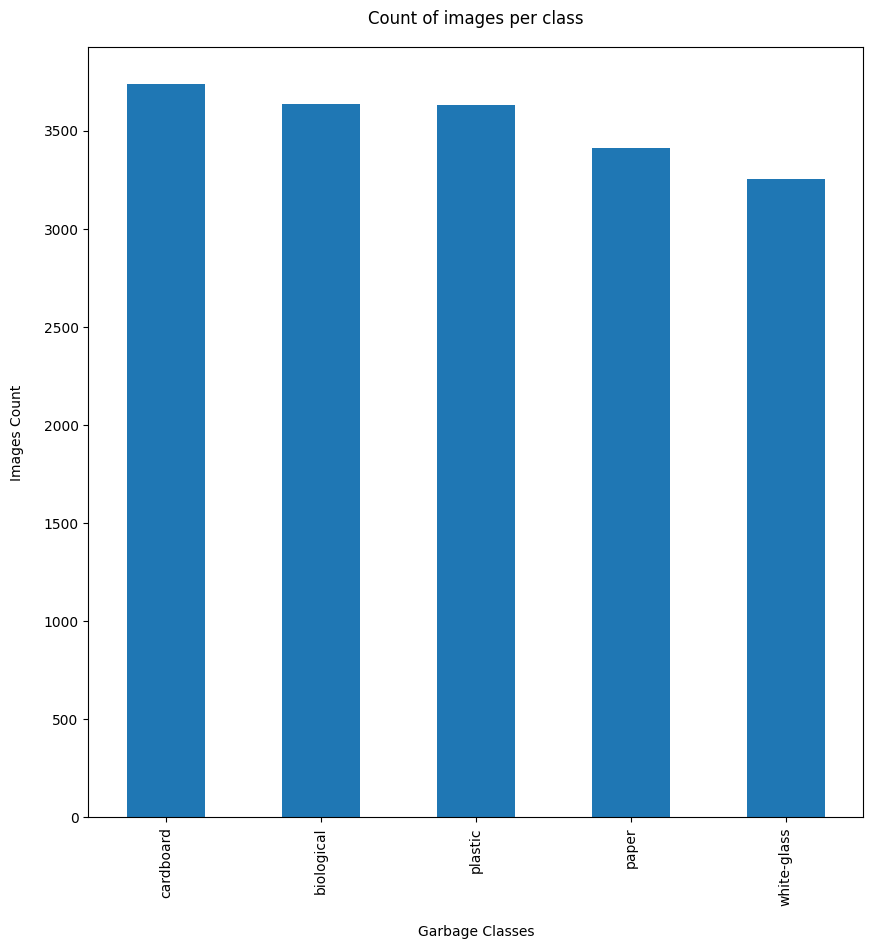

In [15]:
print("distribution class for train")
viz_class_distribution(df_train)

distribution class for train


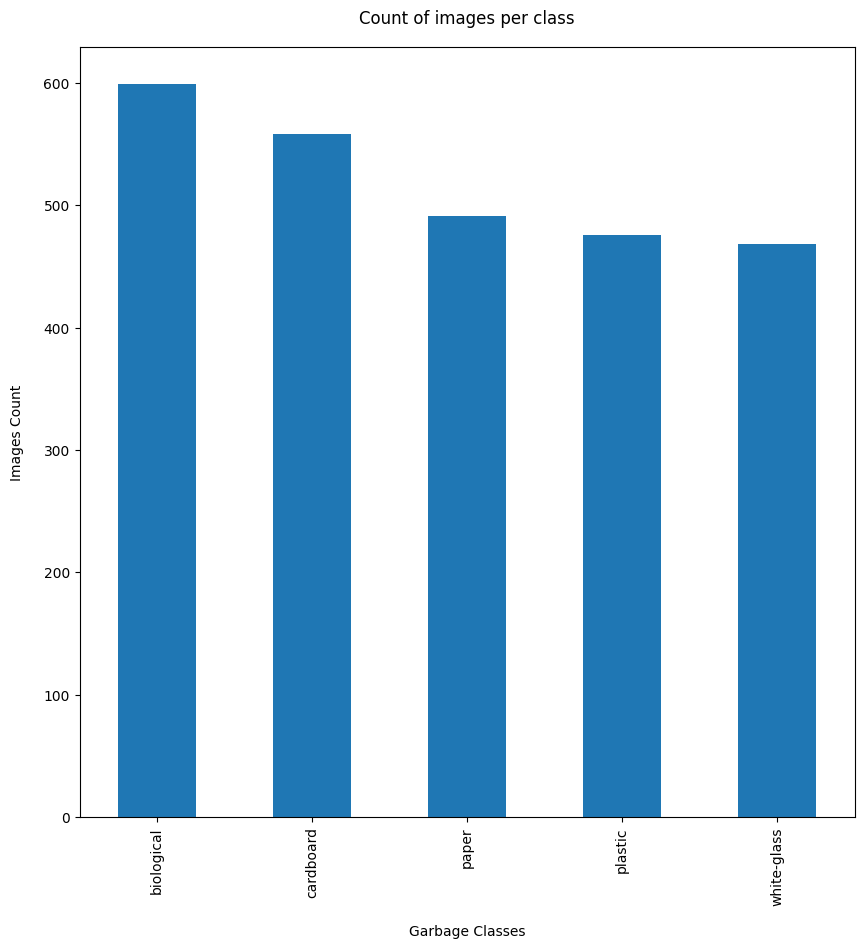

In [16]:
print("distribution class for train")
viz_class_distribution(df_val)

## Imagen de ejemplo

paper24_0_7197.jpeg


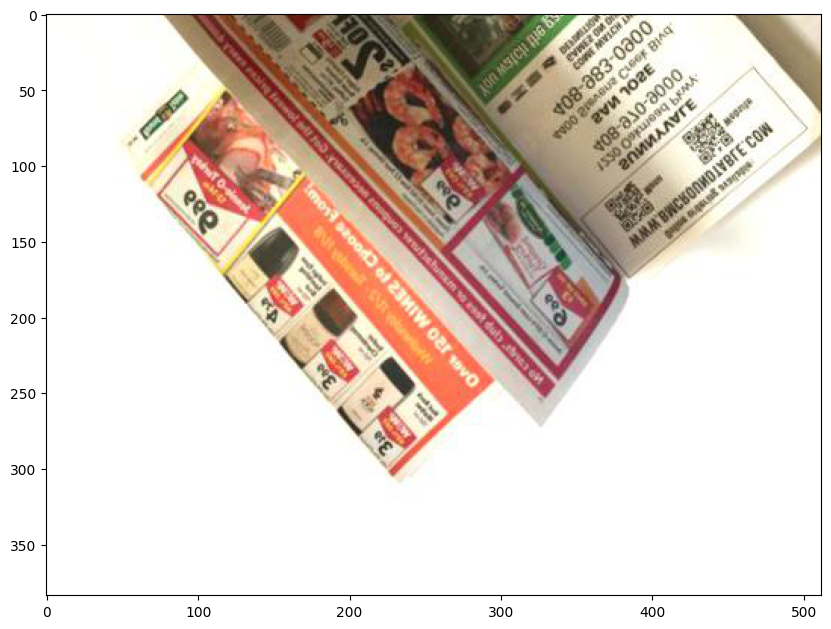

In [ ]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df_train)-1)
sampledir = df_train.iloc[random_row]['filename'].split("/")[0]
sample = df_train.iloc[random_row]['filename'].split("/")[1]
print(sample)
randomimage = image.load_img(train_dir + "/" + sampledir + "/" + sample)
plt.imshow(randomimage)

# Keras


Vamos a entrenar un modelo unicamente con las cinco clases principales de basura, ya que cuando se ha intentado con las doce clases diferentes que hay en el dataset original los resultados son bastante deficientes, aun habiendo balanceado el número de clases que hay en cada una de las categorías. 

En este caso las cinco clases selecionadas también tienen prácticamente el mismo número de imagenes,
 tanto en el conjunto de entrenamiento como en e conjunto de validación tal y como se puede ver en ambos histogramas previos.

Para evitar tener que copiar todas las imagenes de estas cinco categorías (biologicas, plastico, papel, cartón y vidrio) se toma la decisión de cargar las imagenes y etiquetas desde un dataframe, para ello es necesario crear este dataframe, donde estén las rutas de todas las imagenes en una de las columnas y en la otra columna deben de estar la clase a la que pertenecen, llamada label. Es necesario crear un dataframe para el training set, otro para el set de validación y un último para test set. 

In [10]:
import os
import pandas as pd
import imghdr

train_dir = ['/content/drive/MyDrive/PracticaImagenes/garbage_classification/train/paper',              
             '/content/drive/MyDrive/PracticaImagenes/garbage_classification/train/biological',             
             '/content/drive/MyDrive/PracticaImagenes/garbage_classification/train/plastic',             
             '/content/drive/MyDrive/PracticaImagenes/garbage_classification/train/cardboard',             
             '/content/drive/MyDrive/PracticaImagenes/garbage_classification/train/white-glass']

data_train = []




for folder in train_dir:
    for file in os.listdir(folder):
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png') or file.endswith('.bmp')  :
            data_train.append((os.path.join(folder, file), folder.split('/')[-1]))

df_train_5_categories = pd.DataFrame(data_train, columns=['filename', 'label'])


validation_dir = ['/content/drive/MyDrive/PracticaImagenes/garbage_classification/validation/paper',              
             '/content/drive/MyDrive/PracticaImagenes/garbage_classification/validation/biological',             
             '/content/drive/MyDrive/PracticaImagenes/garbage_classification/validation/plastic',             
             '/content/drive/MyDrive/PracticaImagenes/garbage_classification/validation/cardboard',             
             '/content/drive/MyDrive/PracticaImagenes/garbage_classification/validation/white-glass']

data_validation = []




for folder in validation_dir:
    for file in os.listdir(folder):
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png') or file.endswith('.bmp')  :
            data_validation.append((os.path.join(folder, file), folder.split('/')[-1]))

df_validation_5_categories = pd.DataFrame(data_validation, columns=['filename', 'label'])


test_dir = ['/content/drive/MyDrive/PracticaImagenes/garbage_classification/test/paper',              
             '/content/drive/MyDrive/PracticaImagenes/garbage_classification/test/biological',             
             '/content/drive/MyDrive/PracticaImagenes/garbage_classification/test/plastic',             
             '/content/drive/MyDrive/PracticaImagenes/garbage_classification/test/cardboard',             
             '/content/drive/MyDrive/PracticaImagenes/garbage_classification/test/white-glass']

data_test = []


for folder in test_dir:
    for file in os.listdir(folder):
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png') or file.endswith('.bmp')  :
            data_test.append((os.path.join(folder, file), folder.split('/')[-1]))

df_test_5_categories = pd.DataFrame(data_test, columns=['filename', 'label'])



In [11]:
df_train_5_categories.head()


filename  label
0  /content/drive/MyDrive/PracticaImagenes/garbag...  paper
1  /content/drive/MyDrive/PracticaImagenes/garbag...  paper
2  /content/drive/MyDrive/PracticaImagenes/garbag...  paper
3  /content/drive/MyDrive/PracticaImagenes/garbag...  paper
4  /content/drive/MyDrive/PracticaImagenes/garbag...  paper

In [12]:
df_validation_5_categories.head()


filename  label
0  /content/drive/MyDrive/PracticaImagenes/garbag...  paper
1  /content/drive/MyDrive/PracticaImagenes/garbag...  paper
2  /content/drive/MyDrive/PracticaImagenes/garbag...  paper
3  /content/drive/MyDrive/PracticaImagenes/garbag...  paper
4  /content/drive/MyDrive/PracticaImagenes/garbag...  paper

In [13]:
df_test_5_categories.head()

filename  label
0  /content/drive/MyDrive/PracticaImagenes/garbag...  paper
1  /content/drive/MyDrive/PracticaImagenes/garbag...  paper
2  /content/drive/MyDrive/PracticaImagenes/garbag...  paper
3  /content/drive/MyDrive/PracticaImagenes/garbag...  paper
4  /content/drive/MyDrive/PracticaImagenes/garbag...  paper

Una vez creados los diferentes dataframes, se va a utiliar la funcion de flow_drom_dataframe para poder cargar las imágenes desde los dataframes recien creados. 

In [11]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train_5_categories,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test_5_categories,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=df_validation_5_categories,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 17662 validated image filenames belonging to 5 classes.
Found 913 validated image filenames belonging to 5 classes.
Found 2592 validated image filenames belonging to 5 classes.


Ahora se define la estructura del modelo que se va a utilizar para clasificar las cinco categorías difernetes. 

Se va a entrenar una red convolucional estructurada de la siguietne forma
  

*   5 capas de convolución que la primera empieza en 32 filtros de tamaño 3x3 y la última tiene 512 filtros del mismo tamaño
*   Intercaladas con esas capas de convolucion hay capas de pooling, que lo que hacen es diminuir el tamaño de las imagenes de entrada. 
*   Después de estas capas se mete una capa de Flatten para convertir la salida de la última capa de Max Pooling en un vector plano, que va a poder alimentar a una red neuronal completamente conectada. 
*   Después hay una capa Dense completamente conectada co 512 neuronas y una función de activación ReLu. 
*   Una capa de Dropout con una tasa del 10%, lo cual significa que el 20% de las conexiones entre las capas anteriores se eliminaran al azar durante el entrenamiento para evitar el sobreajuste. Se ha intentado con varios porcentajes, pero el modelo sigue saliendo sobreentrando.
*   Una última capa Dense con 5 neuronas, correspondientes a las 5 clases de salida, en las que se pueden clasificar. Con una función de activación softmax que se utilizará para que la salida de la red represente la probabilidad de cada clase.









In [12]:
model_5_categories = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.20),
    Dense(5, activation='softmax')
])

En el siguiente paso se va a proceder a entrenar el modelo. 

Lo primero que se hace es especificar la ubicación donde se van a guardar los pesos del modelo. 

Depues se crea un objeto de tipo ModelCheckpoint, que se utiliza para guardar los pesos del modelo despues de cada epoch, siempre y cuando la emtrica del val_accuracy mejore.

Después se compila el modelo con el optimizador Adam, la función de pérdida es categorical_crossentropy y la metrica de accuracy. 

Además se va a añadir el parametro de learning rate, pera que el modelo vaya aprendiendo poco a poco y no sobre aprenda.

Por último el modelo se entrena utilizando el método de fit(). Se especifica el generador de datos del entrenamiento, el numero de pasos por epoch, el número de epochs, el generador de datos de validación por epoch y el nivel de verbosidad.

In [13]:
from keras.callbacks import ReduceLROnPlateau

checkpoint_path = "/content/drive/MyDrive/PracticaImagenes/checkpoints/model_5_categories_weights.h5"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch'
)

# Compile the model with the same settings as the original model
model_5_categories.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=0.00001)

history = model_5_categories.fit(
    train_generator,
    steps_per_epoch=339,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[checkpoint, lr_reduce],
    verbose = 1
)


Epoch 1/10
339/339 [==============================] - 2802s 8s/step - loss: 1.0976 - accuracy: 0.5397 - val_loss: 1.4227 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 2/10
339/339 [==============================] - 1240s 4s/step - loss: 0.8280 - accuracy: 0.6799 - val_loss: 2.2759 - val_accuracy: 0.4757 - lr: 0.0010
Epoch 3/10
339/339 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.7333
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
339/339 [==============================] - 1146s 3s/step - loss: 0.6964 - accuracy: 0.7333 - val_loss: 1.8754 - val_accuracy: 0.5436 - lr: 0.0010
Epoch 4/10
339/339 [==============================] - 1146s 3s/step - loss: 0.5298 - accuracy: 0.7990 - val_loss: 1.5752 - val_accuracy: 0.5181 - lr: 1.0000e-04
Epoch 5/10
339/339 [==============================] - ETA: 0s - loss: 0.4981 - accuracy: 0.8090
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
339/339 [========================

Se guarda la arquitectura del modelo y los pesos.

In [14]:
# Guardamos la arquitectura del modelo y los pesos
model_5_categories.save('/content/drive/MyDrive/PracticaImagenes/checkpoints/model_5_categories.h5')
model_5_categories.save_weights('/content/drive/MyDrive/PracticaImagenes/checkpoints/model_5_categories_weights.h5')

### Resume Training

La siguiente celda se deja en caso de que debido al tiempo que tarda en entrenar el modelo, se haya tenido que dejar a medias y sea necesario seguir entrenado al modelo desde la epoch que se haya guardado. 

In [ ]:
checkpoint_path = "/content/drive/MyDrive/PracticaImagenes/checkpoints/model_5_categories_weights.h5"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch'
)

# Load the saved model checkpoint
# checkpoint_weights = "/content/drive/MyDrive/PracticaImagenes/checkpoints/model2_weights.h5"
model_5_categories.load_weights('/content/drive/MyDrive/PracticaImagenes/checkpoints/model_5_categories_weights.h5')

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=0.00001)

# Compile the model
model_5_categories.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

history = model_5_categories.fit(
    train_generator,
    steps_per_epoch=339,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[checkpoint],
    verbose = 1
)

Se guarda la arquitectura del modelo y los pesos del modelo.

In [ ]:
# Guardamos la arquitectura del modelo y los pesos
model_5_categories.save('/content/drive/MyDrive/PracticaImagenes/checkpoints/model_5_categories_weights.h5')
model_5_categories.save_weights('/content/drive/MyDrive/PracticaImagenes/checkpoints/model_5_categories_weights.h5')

Se vuelve a sacar un resumen de la estructura del modelo

In [15]:
# Imprime un resumen de la arquitectura de la CNN
model_5_categories.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

## Resultados del modelo

In [16]:
model_5_categories.load_weights('/content/drive/MyDrive/PracticaImagenes/checkpoints/model_5_categories_weights.h5')

# Compile the model
model_5_categories.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy'])

In [17]:
test_loss, test_acc = model_5_categories.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

28/28 [==============================] - 231s 9s/step - loss: 0.4810 - accuracy: 0.8025
Test loss: 0.4809620678424835
Test accuracy: 0.8024553656578064


In [18]:
# Generate predictions for the test set
y_pred = model_5_categories.predict(test_generator, steps=len(test_generator))

# Get true labels of test data
y_test_classes = test_generator.classes
y_test_labels = test_generator.labels

29/29 [==============================] - 28s 939ms/step


Pintamos la matriz de confusión para ver mejor los resultados obtenidos por el modelo

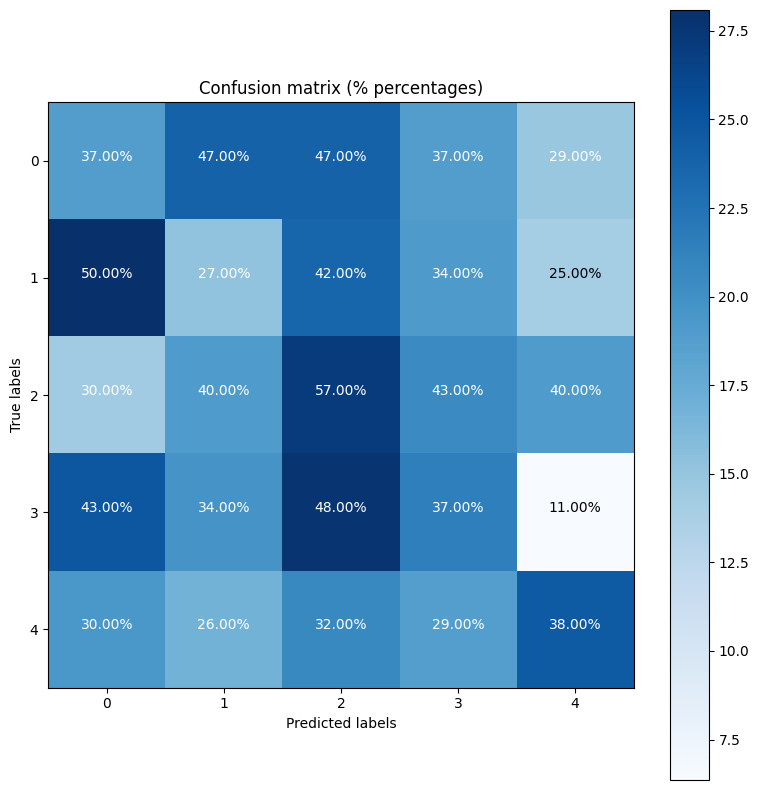

In [19]:

# Calculate the confusion matrix
cm = confusion_matrix(test_generator.classes, np.argmax(y_pred, axis=1))

# Convert counts to percentages
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
im = plt.imshow(cm_perc, cmap=plt.cm.Blues)
plt.xticks(np.arange(5))
plt.yticks(np.arange(5))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix (% percentages)")
plt.colorbar(im)

# Annotate each cell with its value
thresh = cm_perc.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f') + '%',
                 horizontalalignment="center",
                 color="white" if cm_perc[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

Tal y como se puede ver en la matriz de confusión los resultados de este modelo son muy mejorables, ya que en todas las clases la probabilidad de acertar la clase correcta está por debajo del 50%, a excepción de la clase 2, la cual presenta un 63% de acierto, pero tambien tiene porcentajes muy altos para decir que es cualquiera de las otras clases. 



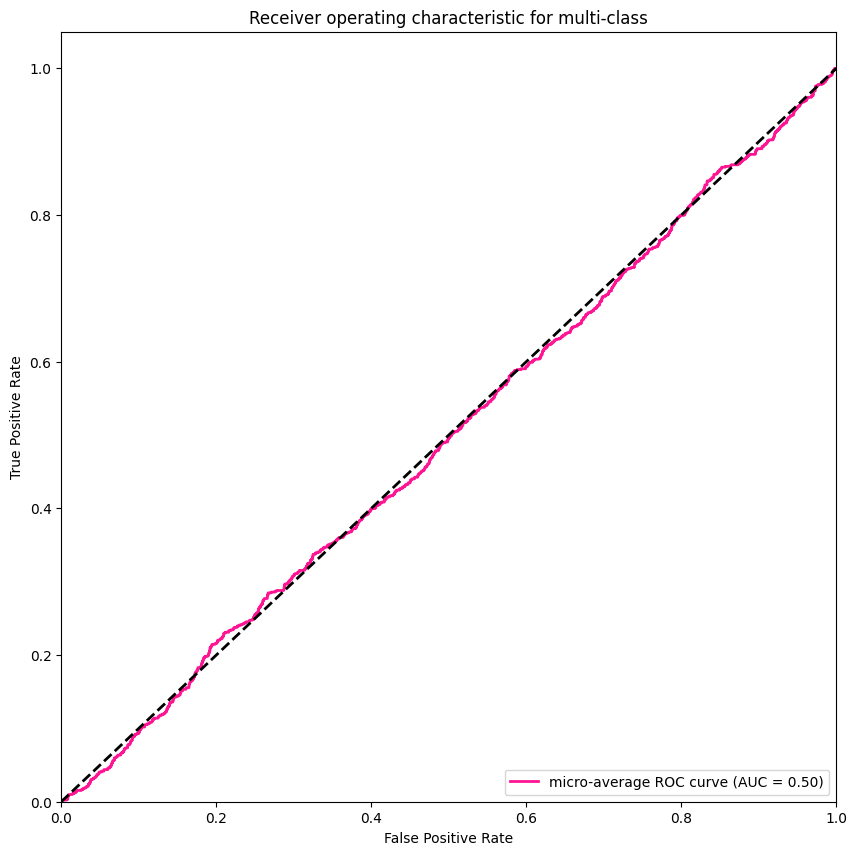

In [20]:
y_test = keras.utils.to_categorical(y_test_labels, len(categories))
# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute the micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves for each class and the micro-average
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='deeppink',
         lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
                ''.format(roc_auc["micro"]))
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray', 'olive', 'cyan', 'magenta', 'black']
# for i, color in zip(range(len(categories)), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (AUC = {1:0.2f})'
#              ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")

plt.show()

Además si pintamos la curva ROC, se puede ver que nuestro modelo equivale casi a una eleccion aleatoria, ya que está muy pegada a la linea negra de puntos. 

Para que fuera un buen modelo, la curva ROC (linea rosa) debería estar lo más cercana posible a la esquina superior izquierda, donde se encuentra el 1 en el eje y.